In [31]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [32]:
%config InlineBackend.figure_format = 'retina'
floatX = pytensor.config.floatX
RANDOM_SEED = 9927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [33]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

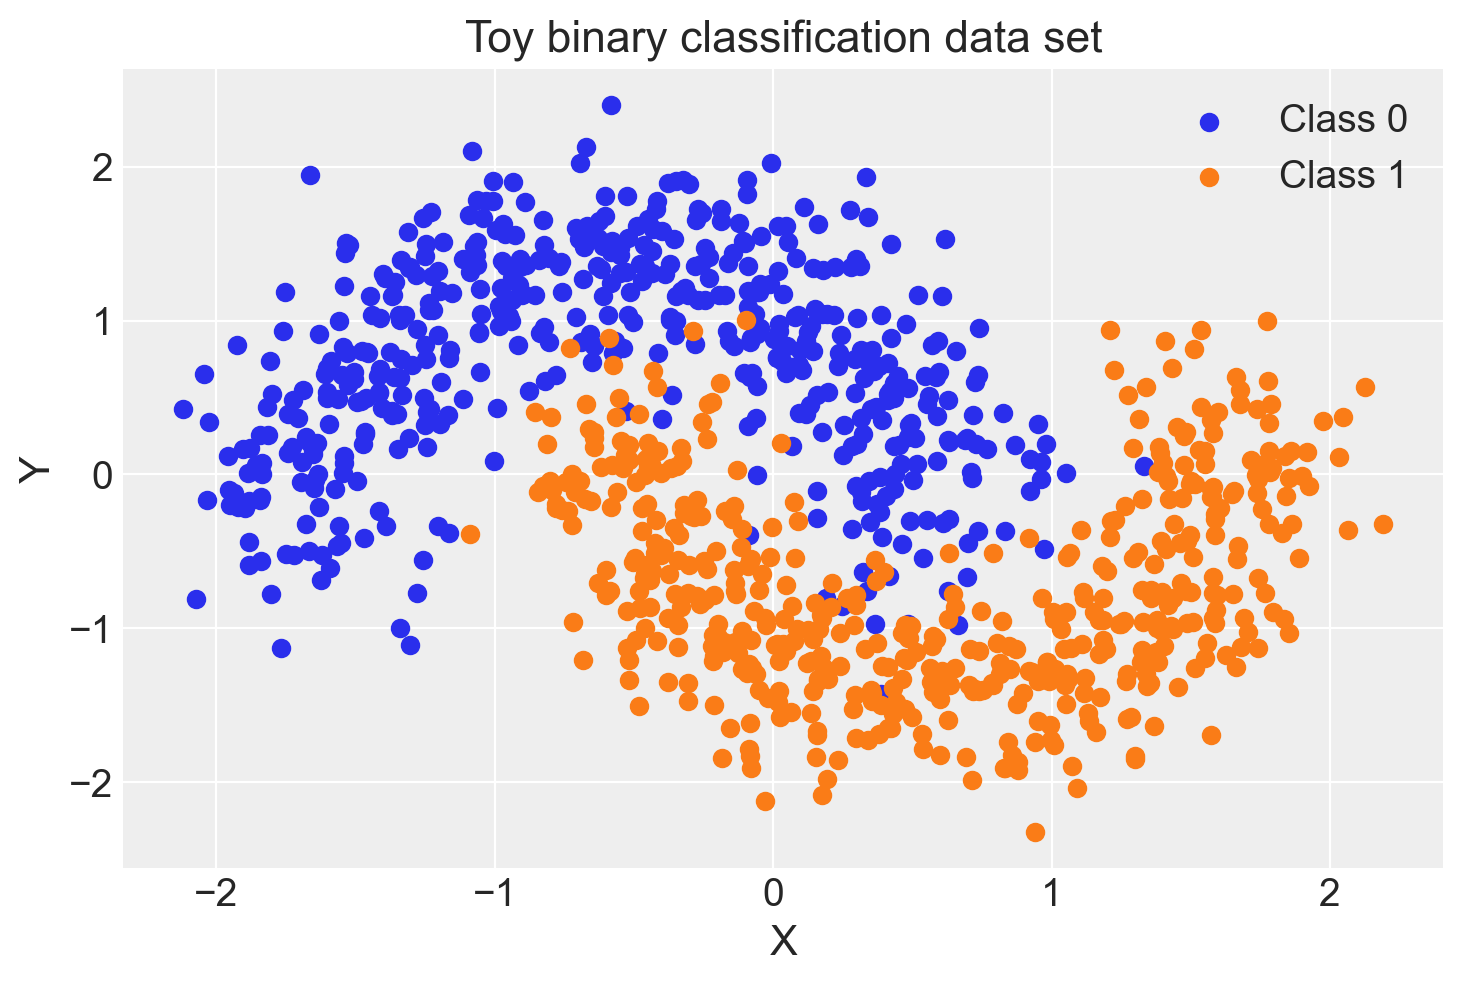

In [34]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], color="C0", label="Class 0")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="C1", label="Class 1")
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Toy binary classification data set");

In [35]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = rng.standard_normal(size=(X_train.shape[1], n_hidden)).astype(floatX)
    init_2 = rng.standard_normal(size=(n_hidden, n_hidden)).astype(floatX)
    init_out = rng.standard_normal(size=n_hidden).astype(floatX)

    coords = {
        "hidden_layer_1": np.arange(n_hidden),
        "hidden_layer_2": np.arange(n_hidden),
        "train_cols": np.arange(X_train.shape[1]),
        # "obs_id": np.arange(X_train.shape[0]),
    }
    with pm.Model(coords=coords) as neural_network:
        ann_input = pm.Data("ann_input", X_train, mutable=True, dims=("obs_id", "train_cols"))
        ann_output = pm.Data("ann_output", Y_train, mutable=True, dims="obs_id")

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal(
            "w_in_1", 0, sigma=1, initval=init_1, dims=("train_cols", "hidden_layer_1")
        )

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal(
            "w_1_2", 0, sigma=1, initval=init_2, dims=("hidden_layer_1", "hidden_layer_2")
        )

        # Weights from hidden layer to output
        weights_2_out = pm.Normal("w_2_out", 0, sigma=1, initval=init_out, dims="hidden_layer_2")

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli(
            "out",
            act_out,
            observed=ann_output,
            total_size=Y_train.shape[0],  # IMPORTANT for minibatches
            dims="obs_id",
        )
    return neural_network


neural_network = construct_nn(X_train, Y_train)

In [36]:
%%time

with neural_network:
    approx = pm.fit(n=10000)

Finished [100%]: Average Loss = 197.45


CPU times: total: 29min 12s
Wall time: 18min 14s


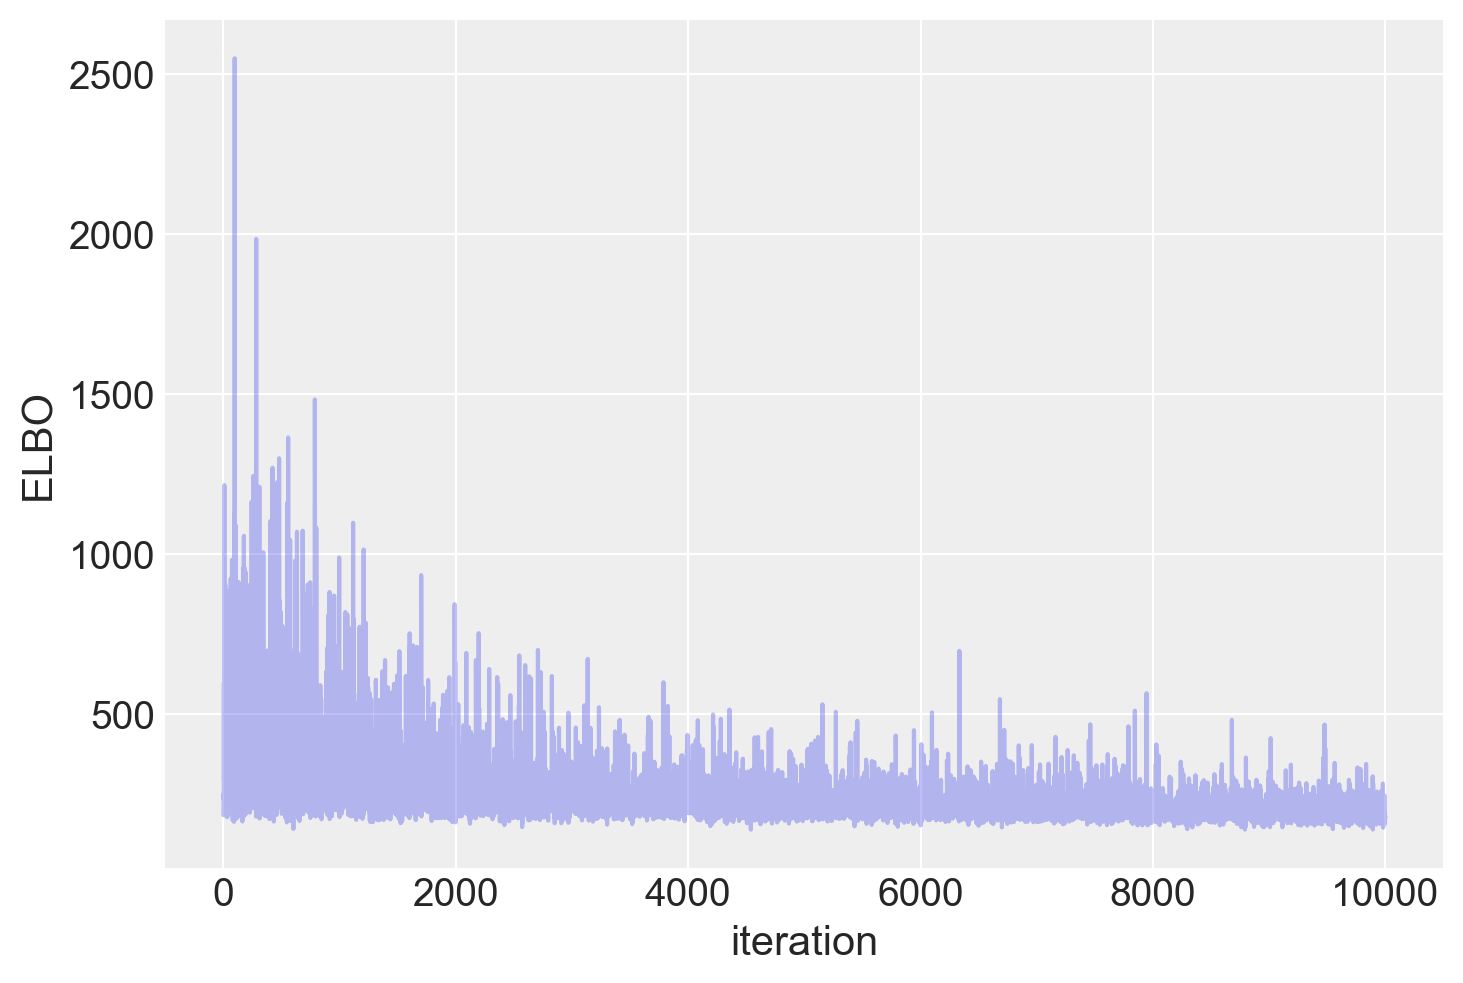

In [37]:
plt.plot(approx.hist, alpha=0.3)
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [38]:
trace = approx.sample(draws=5000)

In [39]:
with neural_network:
    pm.set_data(new_data={"ann_input": X_test})
    ppc = pm.sample_posterior_predictive(trace)
    trace.extend(ppc)

Sampling: [out]


In [40]:
pred = ppc.posterior_predictive["out"].mean(("chain", "draw")) > 0.5

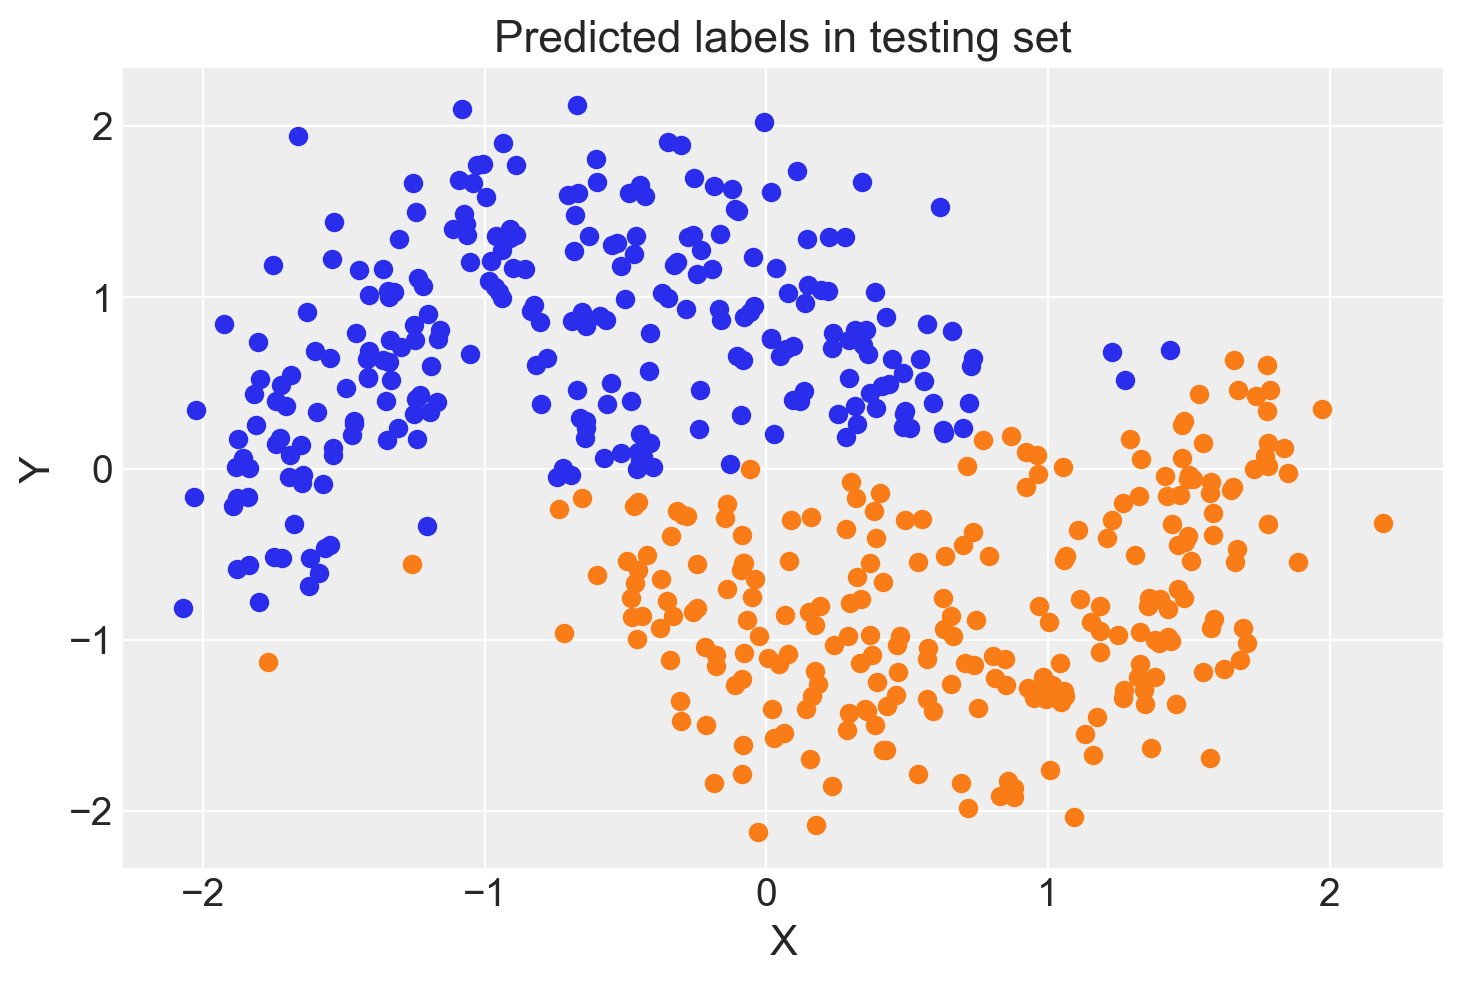

In [41]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
sns.despine()
ax.set(title="Predicted labels in testing set", xlabel="X", ylabel="Y");

In [42]:
print(f"Accuracy = {(Y_test == pred.values).mean() * 100}%")

Accuracy = 87.4%


In [43]:
grid = pm.floatX(np.mgrid[-3:3:100j, -3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [44]:
with neural_network:
    pm.set_data(new_data={"ann_input": grid_2d, "ann_output": dummy_out})
    ppc = pm.sample_posterior_predictive(trace)

C:\Users\rosti\.conda\envs\dementor\Lib\site-packages\pymc\model\core.py:2021: ShapeWarning: You are resizing a variable with dimension 'obs_id' which was initialized as a mutable dimension by another variable ('ann_input'). Remember to update that variable with the correct shape to avoid shape issues.
  model.set_data(variable_name, new_value, coords=coords)
Sampling: [out]


In [45]:
y_pred = ppc.posterior_predictive["out"]

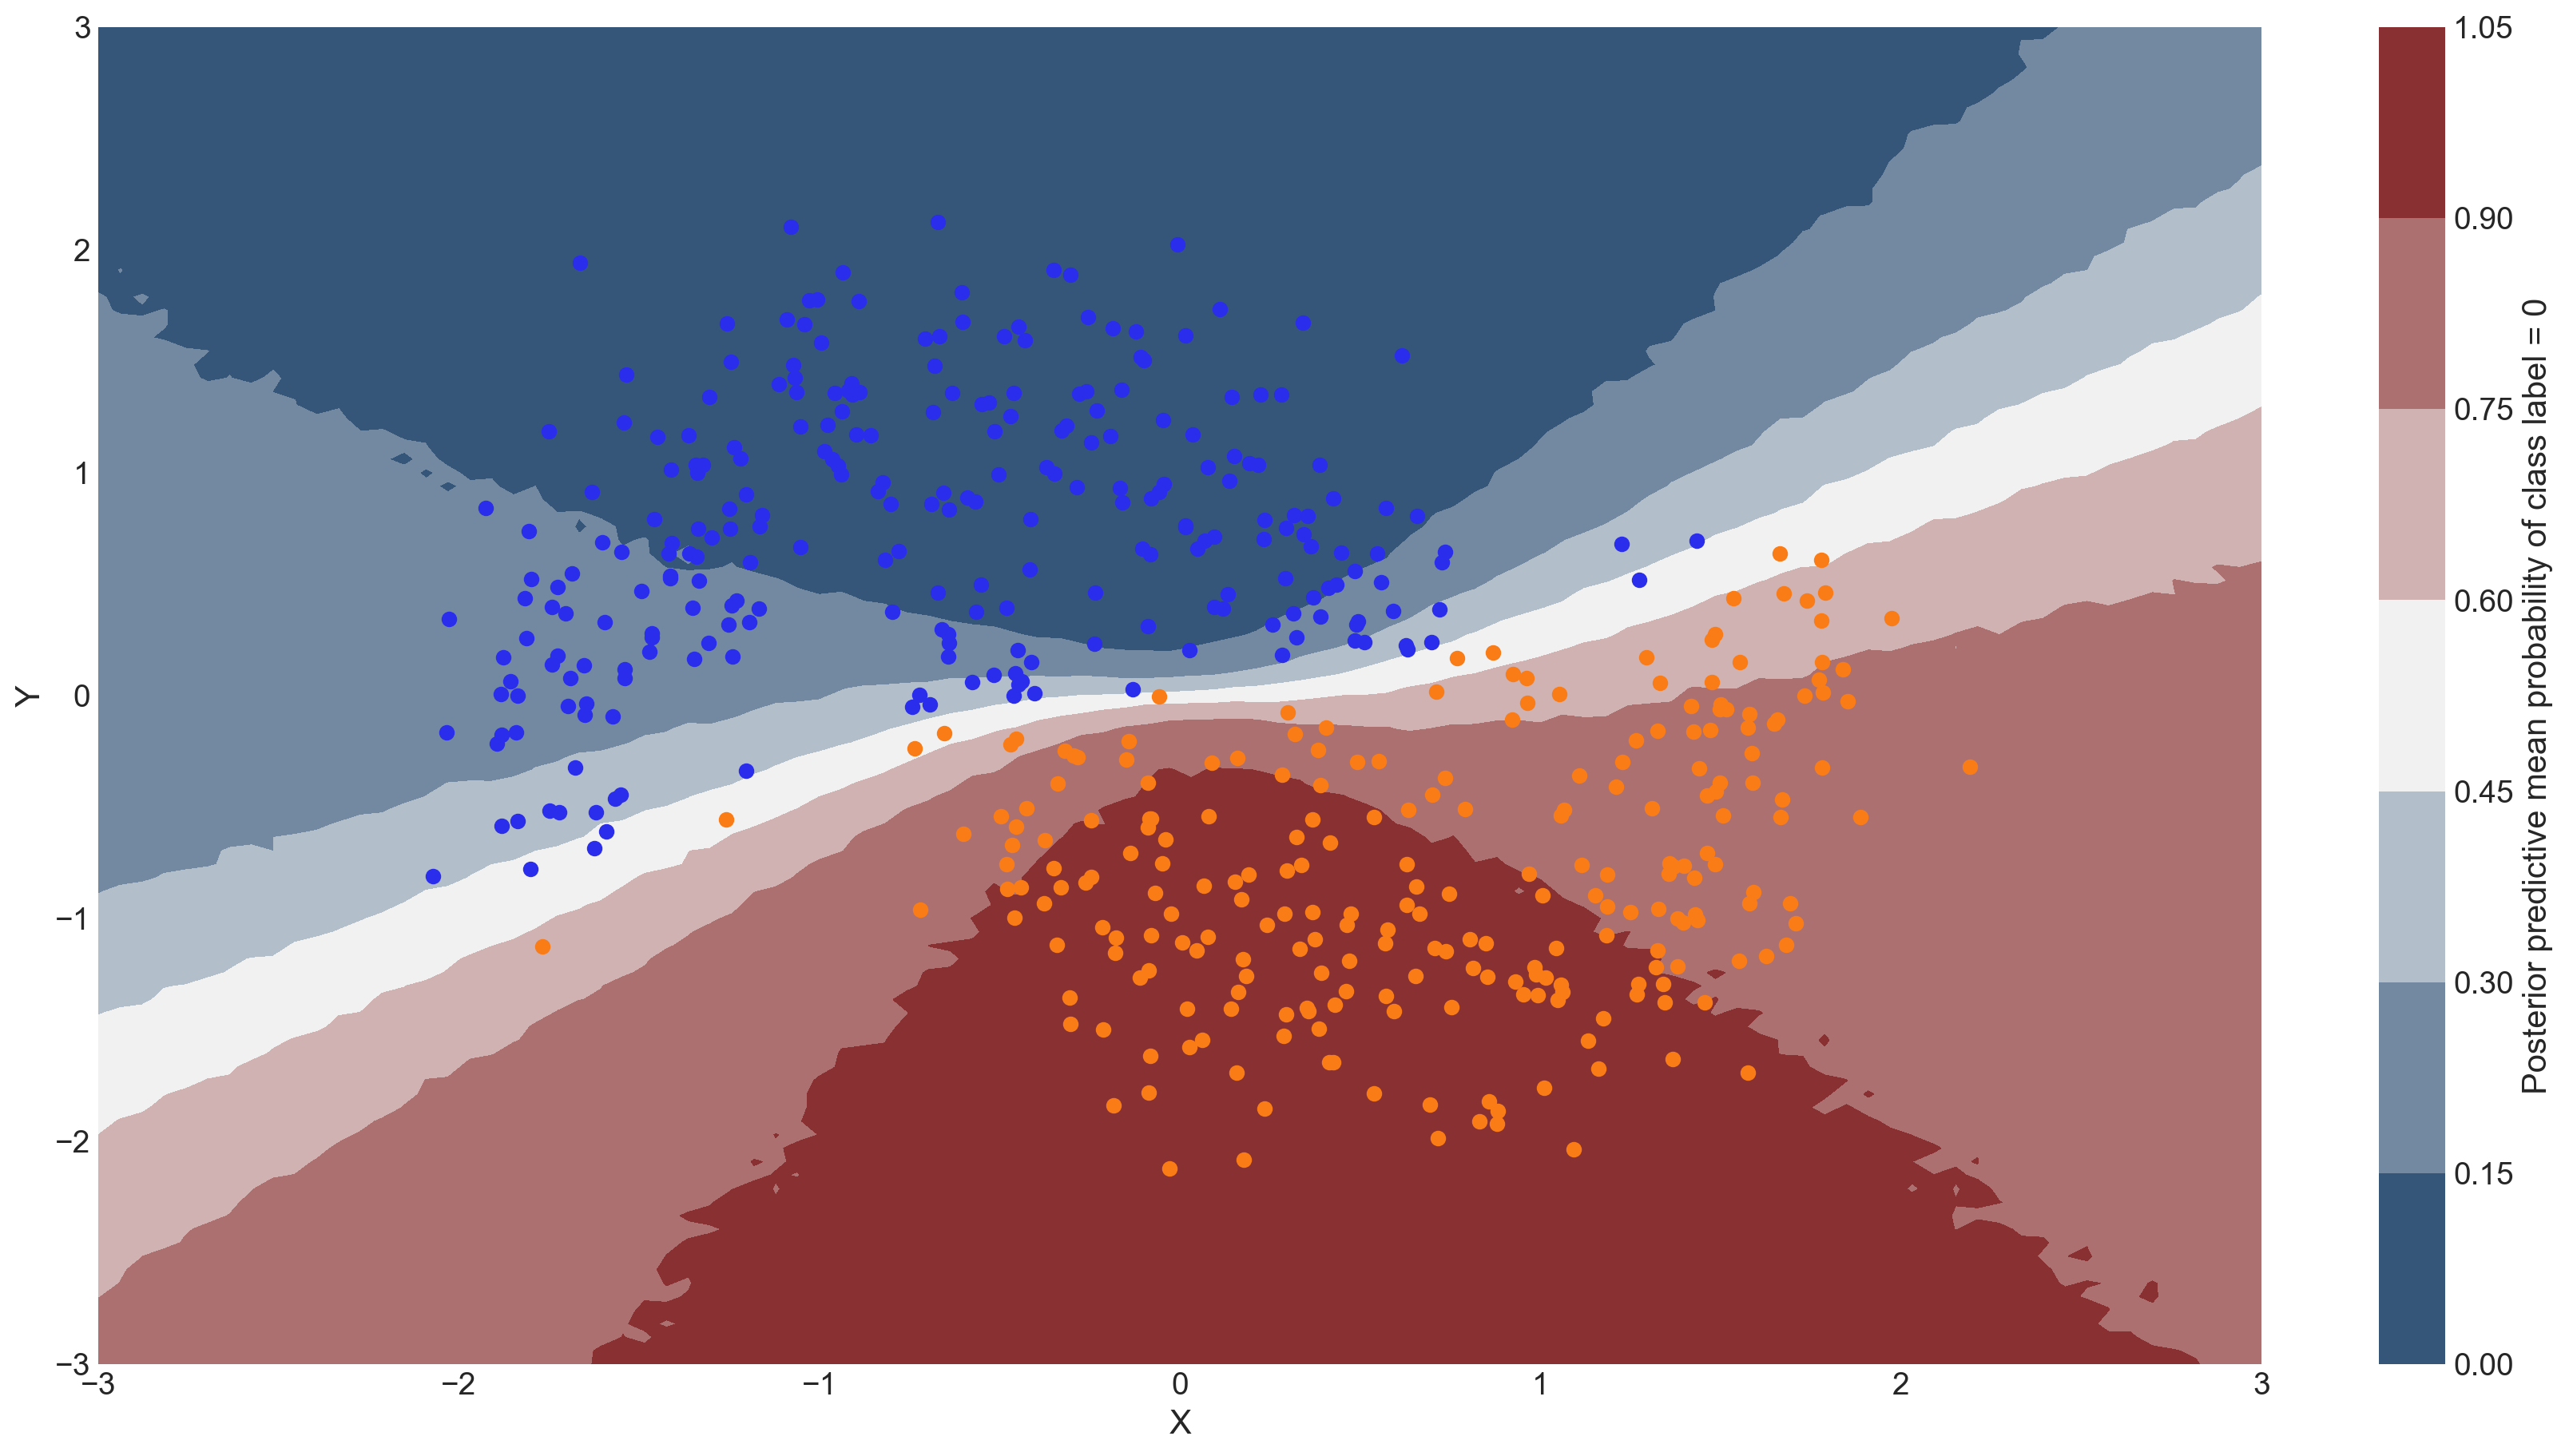

In [46]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(
    grid[0], grid[1], y_pred.mean(("chain", "draw")).values.reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Posterior predictive mean probability of class label = 0");

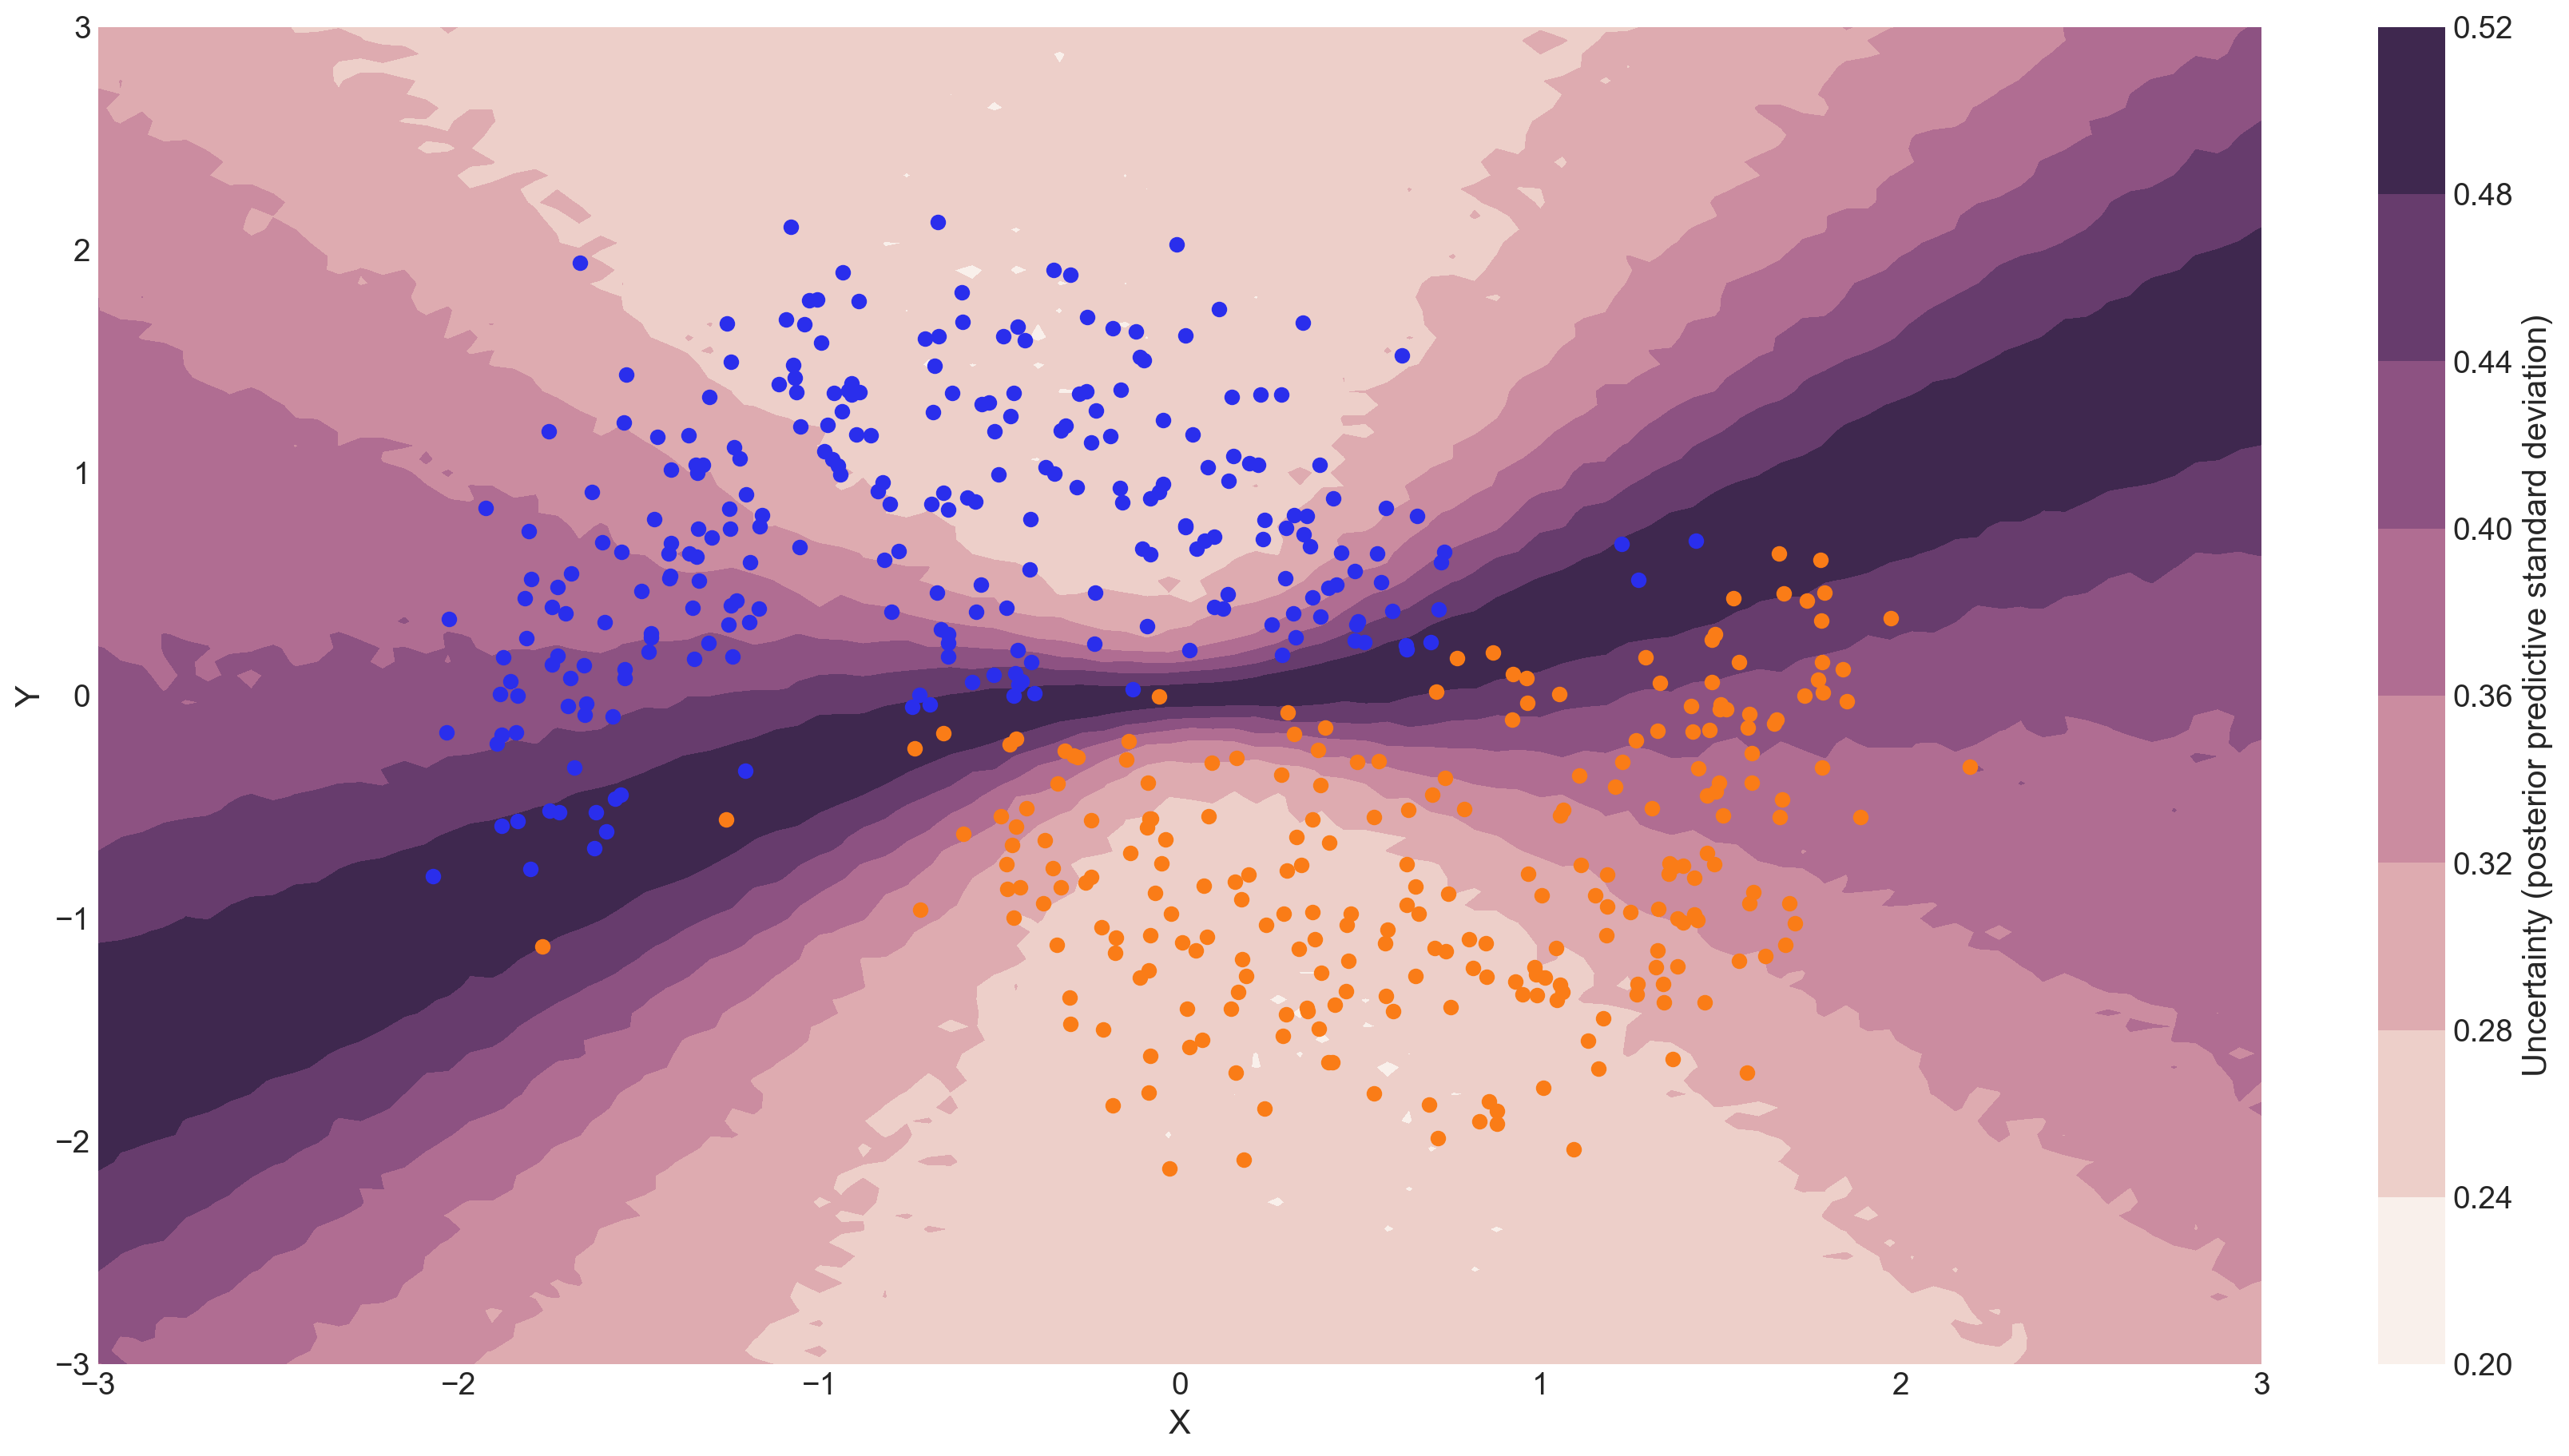

In [47]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(
    grid[0], grid[1], y_pred.squeeze().values.std(axis=0).reshape(100, 100), cmap=cmap
)
ax.scatter(X_test[pred == 0, 0], X_test[pred == 0, 1], color="C0")
ax.scatter(X_test[pred == 1, 0], X_test[pred == 1, 1], color="C1")
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel="X", ylabel="Y")
cbar.ax.set_ylabel("Uncertainty (posterior predictive standard deviation)");

In [25]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(1000, method=pm.ADVI())

Finished [100%]: Average Loss = 457.72


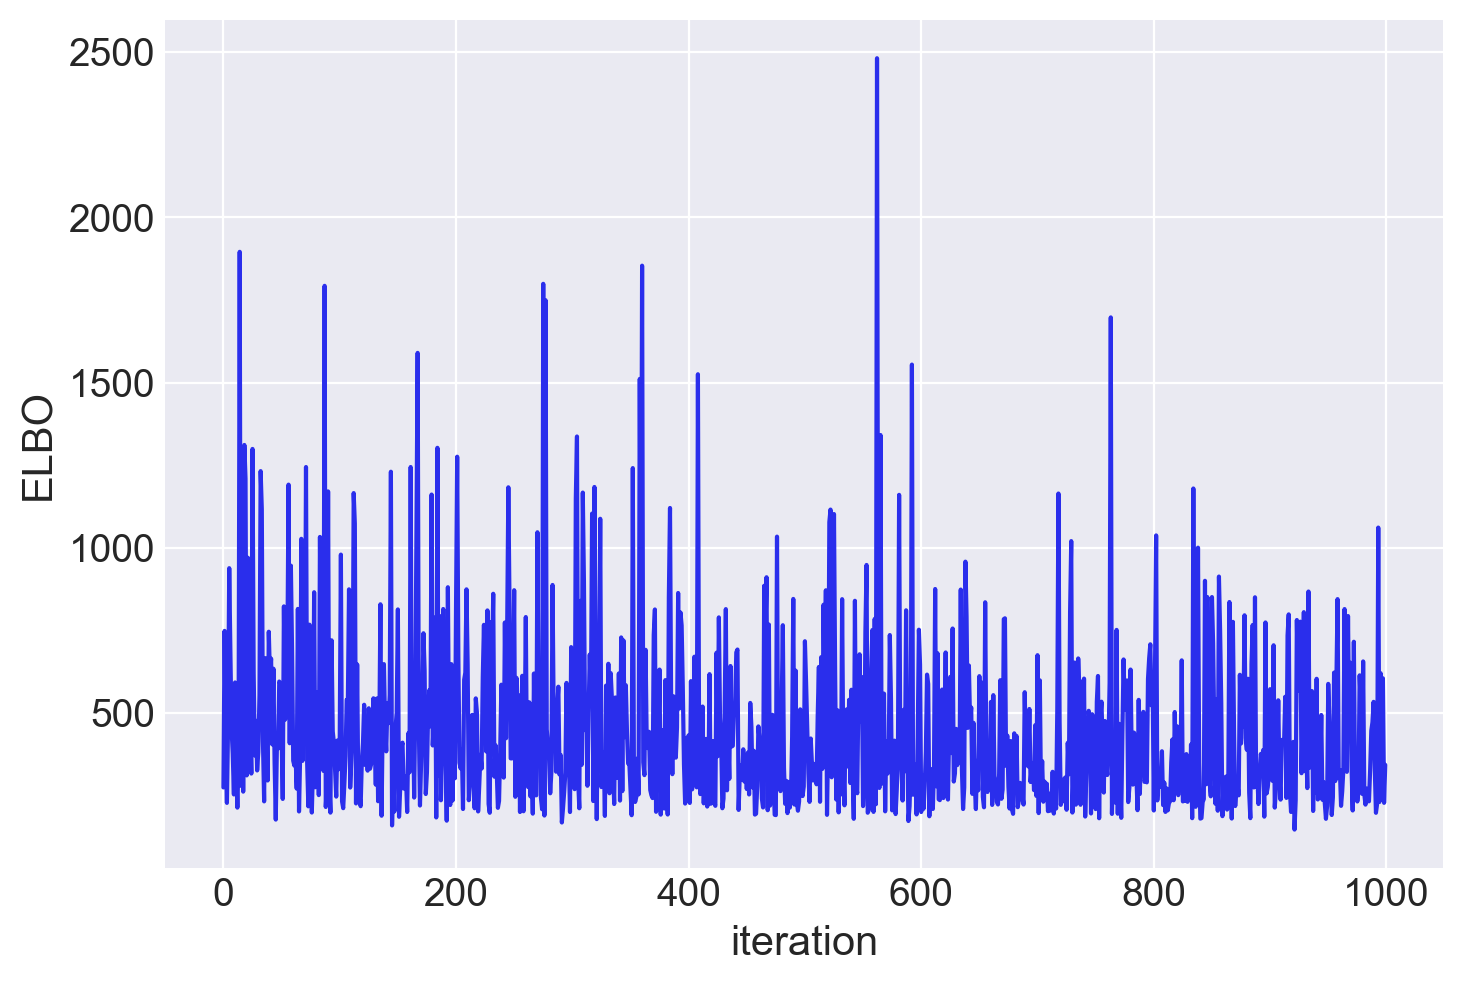

In [26]:
plt.plot(approx.hist)
plt.ylabel("ELBO")
plt.xlabel("iteration");